# OpenAI CLIP

OpenAI introduced the CLIP model in 2021, which took a backseat due to the prominence of DALL-E. This notebook delves into the process of building the CLIP model using PyTorch, offering a simplified approach from paper to code. This is an the second repository in the series called "Paper Replication" in which I try to understand and replicate reseacher paper.

Please check out the previous repo for Replicating Vision Transformer [here](https://github.com/SRDdev/Vision-Transformer)

## What is CLIP ?
In the paper titled "Learning Transferable Visual Models From Natural Language Supervision," OpenAI introduces a new model called CLIP, short for Contrastive Language-Image Pre-training. Simply put, this model learns how sentences and images are related. During training, when given a sentence, the model can retrieve the most relevant images for that sentence. What sets CLIP apart is that it's trained on complete sentences instead of individual categories like cars or dogs. This approach allows the model to learn more and discover patterns between images and text.

The exciting part is that when trained on a large dataset of images and their corresponding texts, CLIP can also work as a classifier. The paper discusses more details about this remarkable model and showcases impressive results on benchmarking datasets. For instance, using this training strategy, the CLIP model outperforms state-of-the-art models trained directly on ImageNet for the specific task of classification! I recommend exploring the paper to delve deeper into the details and discover the astonishing outcomes.

## Why is CLIP important ?
CLIP holds significance due to its groundbreaking approach in learning visual representations through natural language supervision. By understanding the relationships between images and full sentences, it surpasses traditional models and exhibits versatility across tasks such as image classification, object detection, and text comprehension. The model's capability for transfer learning, acquired through training on a diverse dataset, makes it adaptable to various downstream applications. CLIP's release saw increased application primarily because OpenAI provided pre-trained models, facilitating accessibility for developers. Its superior performance on benchmark datasets, coupled with its open-source nature, encouraged widespread adoption and integration into diverse projects. The model's elimination of siloed training and its ability to transfer knowledge seamlessly between modalities have further fueled its application across a spectrum of tasks and domains.

Lets start by installing and importing required libraries like ```timm``` and ```transformers```

In [8]:
!pip install timm -q
!pip install transformers -q

In [9]:
import torch
import matplotlib.pyplot as plt
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

Dataset : [Flicker 30k dataset](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset).

As the data in Flickr-Image-Dataset captions file has 3 columns namely 'image_name', 'comment_number' , 'comments' and we don't need the 'comment_number' column we will preprocess the file and create a `captions.csv ` file

You can also use the 8k version , but from my training results it does not perform well.

In [10]:
dataset = "30k"
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
elif dataset == "30k":
  df = pd.read_csv("/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv", delimiter="|")
  df.columns = ['image', 'caption_number', 'caption']
  df['caption'] = df['caption'].str.lstrip()
  df['caption_number'] = df['caption_number'].str.lstrip()
  df.loc[19999, 'caption_number'] = "4"
  df.loc[19999, 'caption'] = "A dog runs across the grass ."
  ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
  df['id'] = ids
  df.to_csv("/kaggle/working/captions.csv", index=False)
  image_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
  captions_path = "/kaggle/working/captions.csv"

df.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


### Configs
---
Now Let's create a centralized configuration class from where we can tune all the hyperparameters

In [11]:
#----------------------------Configuration------------------#
class config:
    debug = False
    image_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
    captions_path = "/kaggle/working/"
    batch_size = 16
    num_workers = 0
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True 
    trainable = True 
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.0

In [12]:
#-------------------Metric-------------------#
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


### Dataset
---
Let's create a Dataset class to preprocess both images and captions. 

Since machine learning models cannot comprehend natural language in its raw form, we'll utilize the DistilBERT model, a smaller yet efficient alternative to BERT, as our text encoder from the HuggingFace library. To achieve this, we'll tokenize the sentences (captions) using the DistilBERT tokenizer and then supply the token IDs (input_ids) and attention masks to DistilBERT. Consequently, the dataset must handle the tokenization process. 

In the **`__init__`** method, we receive a tokenizer object, which is essentially a HuggingFace tokenizer that will be loaded during model execution. We take care of padding and truncating the captions to a specified max_length. In the **`__getitem__`** method, we first load an encoded caption represented as a dictionary with keys input_ids and attention_mask, convert its values into tensors. Following that, we load the corresponding image, apply transformations and augmentations (if any), convert it into a tensor, and add it to the dictionary with "image" as the key. For visualization purposes only, we include the raw text of the caption in the dictionary with the key "caption."

In [13]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=config.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(config.size, config.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(config.size, config.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

### Image Encoder
---

The CLIP architecture contains a Image Encoder, the authors of the paper mention that the Image encoder can be either a **Convolutional based architecture** or a **Vision Transformer**

In this notebook we will use a convolutional architecture 'resnet50' which is very famous and widely used. For simplicity of the notebook we will not be writing the resnet50 architecture from scratch but we will use one from **timm** library. 

The below code encodes each image to a fixed size vector with the size of the model's output channels **(in case of ResNet50 the vector size will be 2048)**. This is the output after the nn.AdaptiveAvgPool2d() layer.


In [14]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """
    def __init__(
        self, model_name=config.model_name, pretrained=config.pretrained, trainable=config.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

### Text Encoder
---

The CLIP architecture also has a text encoder model as disscused before , for this authors again have mentioned that it could either be **CBOW** or a **Text Traansformer** , for the sake of this tutorial we will be using the famous DistilBERT model from transformers library.

The actual input tokens are augmented with two special tokens: CLS and SEP, denoting the start and end of a sentence. Following the guidance from both BERT and DistilBERT papers, we extract the comprehensive representation of a sentence by utilizing the final representations of the CLS token. The intention is for this representation to encapsulate the overall meaning of the sentence or caption. Conceptually, this process aligns with the approach taken for images, where they are converted into fixed-size vectors.

For DistilBERT (as well as BERT), the output hidden representation for **each token comprises a vector with a size of 768**. Consequently, the entire caption is encoded within the representation of the CLS token, which itself has a size of 768.

In [15]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=config.text_encoder_model, pretrained=config.pretrained, trainable=config.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

### Projections
---

***Finally we are done with both the embeddings , now we can get the similarity right ? right ?***

No, Actually if we take a closer look the Image-Embeddings are 768 dimensions and the text embeddings are 2048 dimensions. This means that we cannot directly compare them to each other , we need to convert them into a intermediate state where both have the same dimensions.

For this we will be using Projection Head , this is directly taken from [keras codes](https://keras.io/examples/vision/nl_image_search/) and will generate 256 dimensional vectors for images and texts.

The term **"embedding_dim"** refers to the size of the input vector, set at **2048 for images and 768 for texts**. On the other hand, **"projection_dim"** denotes the size of the output vector, which, in our case, is specified as **256**. For a more comprehensive understanding of this aspect, detailed insights can be found in the CLIP paper.

In [16]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=config.projection_dim,
        dropout=config.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

### CLIP
---
![CLIP](https://production-media.paperswithcode.com/methods/3d5d1009-6e3d-4570-8fd9-ee8f588003e7.png)

Now comes the exciting part! We'll delve into the details of the main model and discuss the **loss function**. I've adapted some code from Keras examples into PyTorch for this section. Take a moment to explore the code, and then let's break it down.

In the implementation of the main model, the **`__init__`** function is pretty straightforward. In the "forward" function, we first encode the images and texts into fixed-size vectors with different dimensionalities. Using separate projection modules, we then map them to a shared space, as mentioned earlier, where both encodings become similar in shape (256 in our case). Following this, we compute the loss, which I'll try my best to explain, although I recommend reading the CLIP paper for a deeper understanding.

In Linear Algebra, a common way to measure the similarity between two vectors is to calculate their dot product – multiplying matching entries and summing them up. If the result is large, the vectors are considered similar, and if it's small, they are not (relatively speaking).

Now, here's the key idea: instead of dealing with two individual vectors, we have two groups of vectors – image_embeddings (a matrix with shape [batch_size, 256]) and text_embeddings (another matrix with the same shape). To measure how similar these two groups of vectors are, we use the dot product (denoted by the "@" operator in PyTorch). To perform this multiplication, we transpose the second matrix, resulting in a matrix with shape [batch_size, batch_size], referred to as logits. The temperature is set to 1.0 in our case (you can experiment with different values), and you can refer to the paper to understand its significance.

Now, let's move on to obtaining targets. There's a more straightforward way, but for our case, I had to take a slightly different approach, which I'll explain in the next paragraph.

Our objective is for the model to learn similar representations (vectors) for a given image and its corresponding caption. Whether we input an image or its description, we want the model to generate identical 256-sized vectors for both. If this seems a bit complex, feel free to review the code and check the shapes to solidify your understanding.

In [17]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=config.temperature,
        image_embedding=config.image_embedding,
        text_embedding=config.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

### Train
---
Below functions are helper functions for training the CLIP model.

In [18]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not config.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [19]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(config.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def trainer():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(config.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": config.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": config.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": config.head_lr, "weight_decay": config.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=config.patience, factor=config.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(config.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "/kaggle/working/model.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Train the model. This will require 30min on GPU-P100

In [20]:
trainer()

Epoch: 1


  0%|          | 0/3973 [00:00<?, ?it/s]

  0%|          | 0/994 [00:00<?, ?it/s]

Saved Best Model!


In [21]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(config.device)
    model.load_state_dict(torch.load(model_path, map_location=config.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(config.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [27]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "/kaggle/working/model.pt")

  0%|          | 0/994 [00:00<?, ?it/s]

### Inference
---
The below function will return the relevent images given the model , image_embedding from which we want the results and the input query.

In [28]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

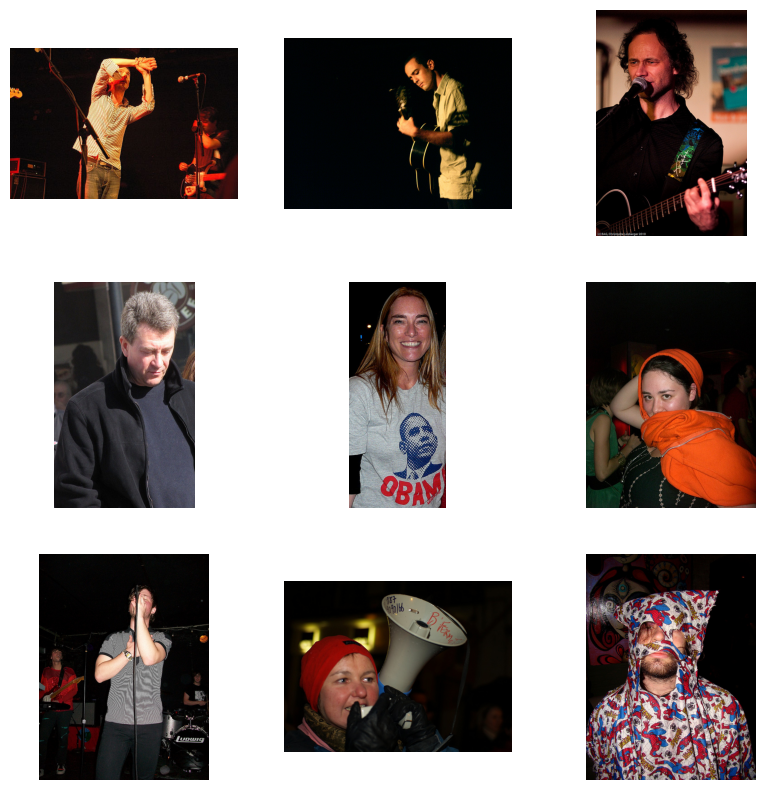

In [31]:
find_matches(model,
             image_embeddings,
             query="a person playing guitar",
             image_filenames=valid_df['image'].values,
             n=9)